<a href="https://colab.research.google.com/github/Ashishkhurana01/Hands-On-LLM/blob/main/ch05_TextClustering%2BTopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Clustering and Topic Modeling

In [1]:
%%capture
!pip install bertopic datasets openai datamapplot

In [2]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [4]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

**Dimensionality Reduction**

In [5]:
from umap import UMAP

# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


**Clustering the EMbeddings**

In [6]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


150

**Clusters Inspection**

In [7]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [8]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(-7.463608884811402,
 11.407711172103882,
 -1.1912264376878738,
 16.967825546860695)

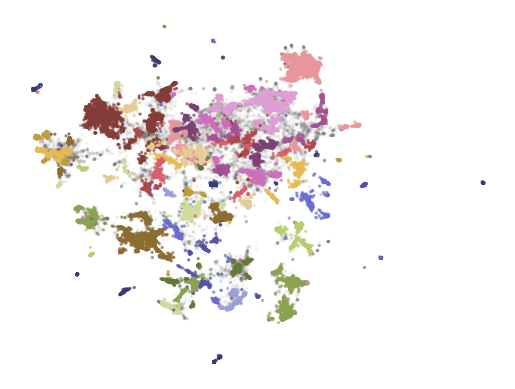

In [9]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

**From Text Clustering to Topic Modeling**

*BERTopic: A Modular Topic Modeling Framework*

In [10]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-01-26 02:28:16,297 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-26 02:29:13,685 - BERTopic - Dimensionality - Completed ✓
2025-01-26 02:29:13,688 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-26 02:29:15,734 - BERTopic - Cluster - Completed ✓
2025-01-26 02:29:15,752 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-26 02:29:19,632 - BERTopic - Representation - Completed ✓


In [11]:
topic_model.get_topic_info()

Topic  Count                                      Name  \
0       -1  14551                          -1_the_of_and_to   
1        0   2224            0_question_qa_questions_answer   
2        1   2050              1_speech_asr_recognition_end   
3        2   1520     2_medical_clinical_biomedical_patient   
4        3    964            3_translation_nmt_machine_bleu   
..     ...    ...                                       ...   
145    144     53       144_gans_gan_adversarial_generation   
146    145     52      145_backdoor_attacks_attack_triggers   
147    146     51      146_counseling_mental_therapy_health   
148    147     51  147_multimodal_modality_fusion_sentiment   
149    148     51    148_coherence_discourse_paragraph_text   

                                        Representation  \
0    [the, of, and, to, in, we, language, for, that...   
1    [question, qa, questions, answer, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [medical, clinical, biomedical, patient, healt...   
4    [translation, nmt, machine, bleu, neural, engl...   
..                                                 ...   
145  [gans, gan, adversarial, generation, generativ...   
146  [backdoor, attacks, attack, triggers, poisoned...   
147  [counseling, mental, therapy, health, psychoth...   
148  [multimodal, modality, fusion, sentiment, moda...   
149  [coherence, discourse, paragraph, text, cohesi...   

                                   Representative_Docs  
0    [  Knowledge-enhanced pre-trained models for l...  
1    [  In open question answering (QA), the answer...  
2    [  Voice Assistants such as Alexa, Siri, and G...  
3    [  Biomedical Named Entity Recognition (NER) i...  
4    [  Neural Machine Translation (NMT) models ach...  
..                                                 ...  
145  [  Text generation is of particular interest i...  
146  [  The prompt-based learning paradigm, which b...  
147  [  Mental health care poses an increasingly se...  
148  [  Multimodal machine learning is a core resea...  
149  [  While there has been significant progress t...  

[150 rows x 5 columns]

In [12]:
# To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the get_topic() function:
topic_model.get_topic(0)

[('question', 0.02145681593936748),
 ('qa', 0.01588839959163033),
 ('questions', 0.01585843213647822),
 ('answer', 0.015727085079070776),
 ('answering', 0.014908290491091976),
 ('answers', 0.00989025089046151),
 ('retrieval', 0.009562015670680156),
 ('comprehension', 0.007837863662310648),
 ('reading', 0.007314196296894196),
 ('the', 0.0063958267469293485)]

In [13]:
topic_model.find_topics("topic modeling")

([22, -1, 2, 45, 30],
 [0.95497566, 0.911328, 0.9087179, 0.90749735, 0.90506303])

In [14]:
topic_model.get_topic(22)

[('topic', 0.06945617465332493),
 ('topics', 0.036023179433915774),
 ('lda', 0.01661929568243725),
 ('latent', 0.013983559515945656),
 ('document', 0.012634641415039357),
 ('documents', 0.012620262980522618),
 ('modeling', 0.012530857445661283),
 ('dirichlet', 0.010302387745128845),
 ('word', 0.008892079799744539),
 ('allocation', 0.008109142901468164)]

In [15]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

22

In [16]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [17]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

# **Rep Models**

In [18]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [19]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

In [20]:
# KeyBERTInspired

from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3        translation | nmt | machine | bleu | neural   
4      4  summarization | summaries | summary | abstract...   

                                             Updated  
0  answering | questions | comprehension | answer...  
1  transcription | speech | phonetic | encoder | ...  
2            nlp | ehr | clinical | annotated | text  
3  translation | translate | translations | trans...  
4  summarization | summarizers | summaries | summ...

**Maximal Marginal Relevance**

In [21]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3        translation | nmt | machine | bleu | neural   
4      4  summarization | summaries | summary | abstract...   

                                             Updated  
0   questions | comprehension | to | knowledge | hop  
1           speech | asr | error | model | automatic  
2  clinical | biomedical | patient | notes | heal...  
3       translation | nmt | bleu | neural | parallel  
4  summarization | document | extractive | rouge ...

**Text Gen**

In [22]:
#Flan T5

from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 150/150 [00:17<00:00,  8.60it/s]


Topic                                           Original  \
0      0     question | qa | questions | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3        translation | nmt | machine | bleu | neural   
4      4  summarization | summaries | summary | abstract...   

                                  Updated  
0          Question answering |  |  |  |   
1  Speech-to-text translation |  |  |  |   
2                Science/Tech |  |  |  |   
3  Neural machine translation |  |  |  |   
4   Abstractive summarization |  |  |  |

In [24]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
with open('/content/drive/My Drive/api_key.txt', 'r') as f:
    api_key = f.read().strip()

In [26]:
#OpenAI
import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# Update our topic representations using GPT-3.5
client = openai.OpenAI(api_key=api_key)
representation_model = OpenAI(
    client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

  0%|          | 0/150 [09:16<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)
plt.savefig("datamapplot.png", dpi=300)